# 1. Get data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from matlab

Dataset shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor labels: (3064,)
Unique labels: [0 1 2]


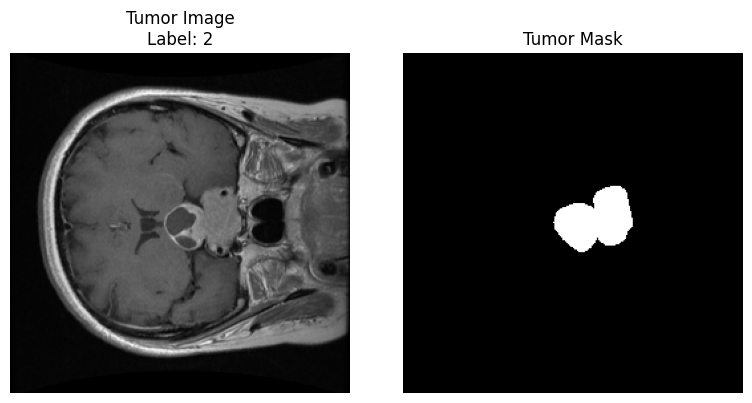

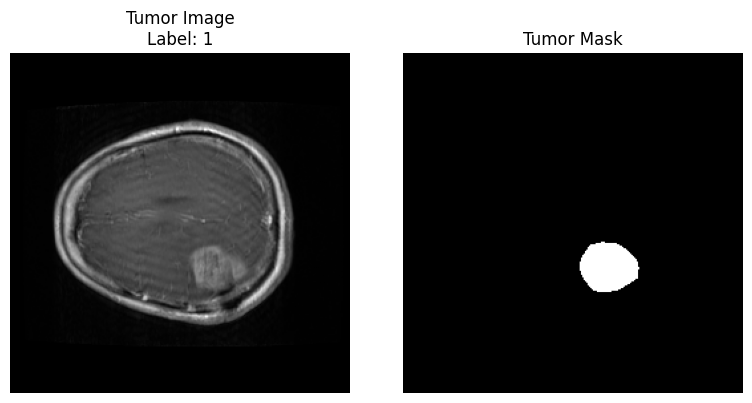

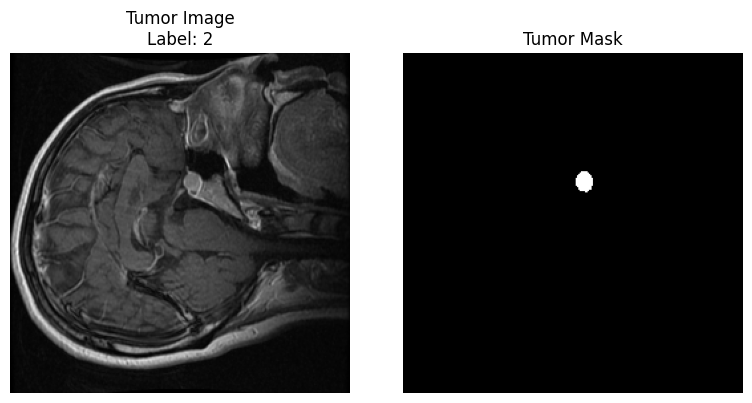

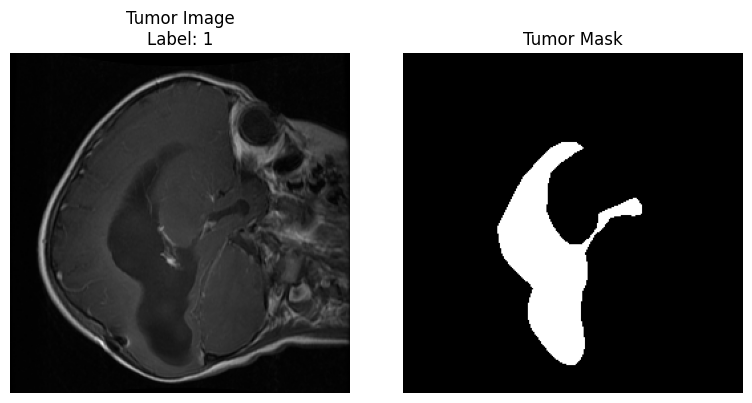

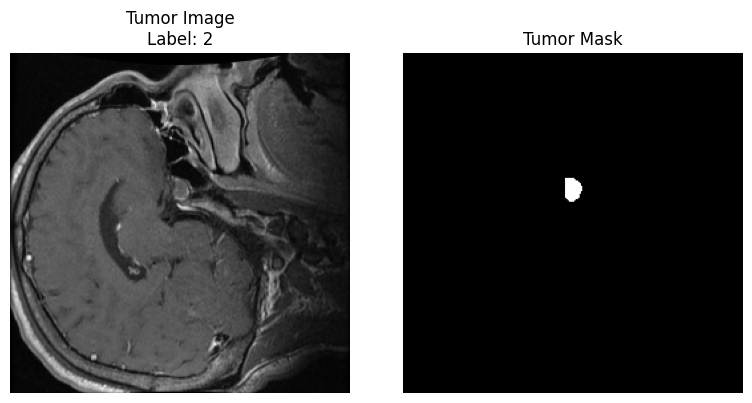

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 1 -> meningioma  2 -> glioma  3 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocess

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)

Processed X_tumor shape: (3064, 256, 256, 1)


# 4. Lightning module

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# torch.manual_seed(42)

# dataset class
class BrainTumorDataset_multi(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        labels -> numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # added for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # # make images, masks and labels torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]  # 0, 1, 2

        return image, mask, label


    # Lightning dataModule
class BrainTumorDataModule_multi(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # added labels here
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset, now includes labels
        full_dataset = BrainTumorDataset_multi(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


# instantiate data module, batch size already set
data_module_multi = BrainTumorDataModule_multi(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module_multi.setup()

# initialize loaders
train_loader_multi = data_module_multi.train_dataloader()
test_loader_multi = data_module_multi.test_dataloader()
for batch in train_loader_multi:
    images, masks, labels = batch  # technically, it should also include labels
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # same here
    print("Batch labels shape:", labels.shape)  # should be (batch_size,)
    break

# this shows how many samples from the test set are for each type of tumor
from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader_multi:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])
Label 0 has 153 images in test set.
Label 1 has 281 images in test set.
Label 2 has 178 images in test set.


# 5. Models

# 5.1 Classification embeddings into seg

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Classification Logits and Segmentation Decoder Modification
class FCNResNet50Lightning_5_1_1(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) projection for classifier logits → 2048 channels
        self.cls_proj = nn.Linear(num_cls_classes, 2048)

        # 3) classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # classification
        class_logits = self.classifier(features)  # [B,3]

        # project & add back to features
        cls_embed = self.cls_proj(class_logits)        # [B,2048]
        cls_embed = cls_embed.view(-1, 2048, 1, 1)     # [B,2048,1,1]
        features = features + cls_embed                # broadcast add

        # segmentation decoder
        seg_logits = self.model.classifier(features)    # [B,1,H/8,W/8]
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[2:],                          # up to original H,W
            mode='bilinear',
            align_corners=False
        )

        return seg_logits, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice  = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce   = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice  = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 5.2 Segmentation embeddings into classification

In [5]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Segmentation Logits
class FCNResNet50Lightning_5_1_2(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) Load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) Create a segmentation feature extractor
        # This will extract features from segmentation decoder
        self.seg_feature_extractor = nn.Sequential(
            nn.Conv2d(num_seg_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        # 3) Classification head that integrates backbone features and segmentation features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 + 64, 512),  # 2048 from backbone + 64 from seg features
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # Losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # Ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Get encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # Run segmentation decoder
        seg_logits = self.model.classifier(features)  # [B,1,H/8,W/8]

        # Extract features from segmentation logits
        seg_features = self.seg_feature_extractor(seg_logits)  # [B,64,H/16,W/16]

        # Global average pooling on both feature sets
        global_features = F.adaptive_avg_pool2d(features, 1)  # [B,2048,1,1]
        global_seg_features = F.adaptive_avg_pool2d(seg_features, 1)  # [B,64,1,1]

        # Concatenate both feature types
        combined_features = torch.cat([
            global_features.flatten(1),
            global_seg_features.flatten(1)
        ], dim=1)  # [B,2048+64]

        # Run classifier on combined features
        class_logits = self.classifier[2:](combined_features)  # Skip pooling & flatten

        # Upsample segmentation to original size
        seg_logits_full = F.interpolate(
            seg_logits,
            size=x.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        return seg_logits_full, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 6. Load models from checkpoint

In [6]:
model_cls_into_seg = FCNResNet50Lightning_5_1_1.load_from_checkpoint('checkpoints/cls_embeddings_into_seg_0.7482seg_0.94cls_weights_0.85_0.15.ckpt')
model_seg_into_cls = FCNResNet50Lightning_5_1_2.load_from_checkpoint('checkpoints/seg_embeddings_into_cls_0.75seg_0.94cls_weights_0.85_0.15.ckpt')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 7. Explainability

# 7.1 Occlusion Analysis

Model 1: Classification Embeddings into Segmentation
Processing Meningioma sample 1/3


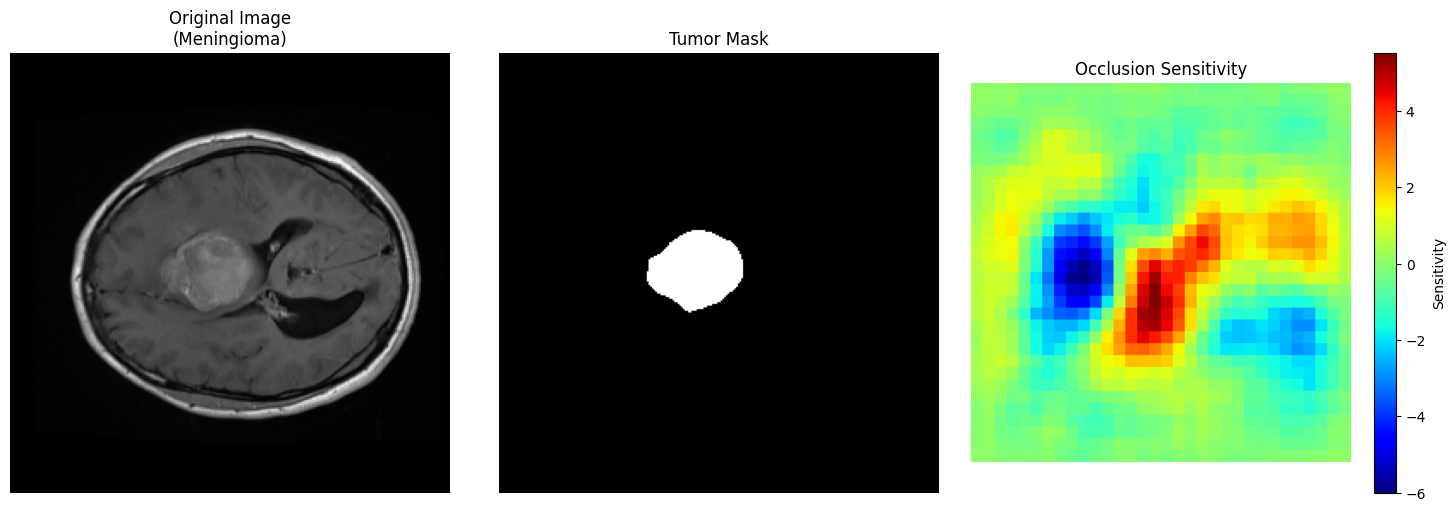

Processing Meningioma sample 2/3


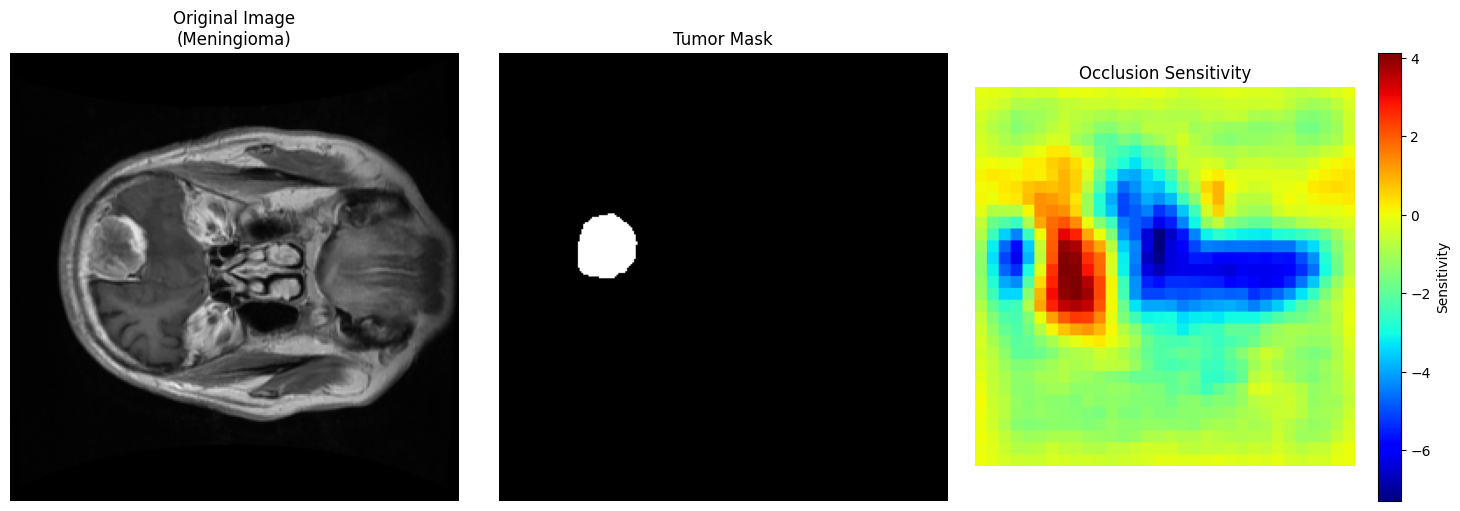

Processing Meningioma sample 3/3


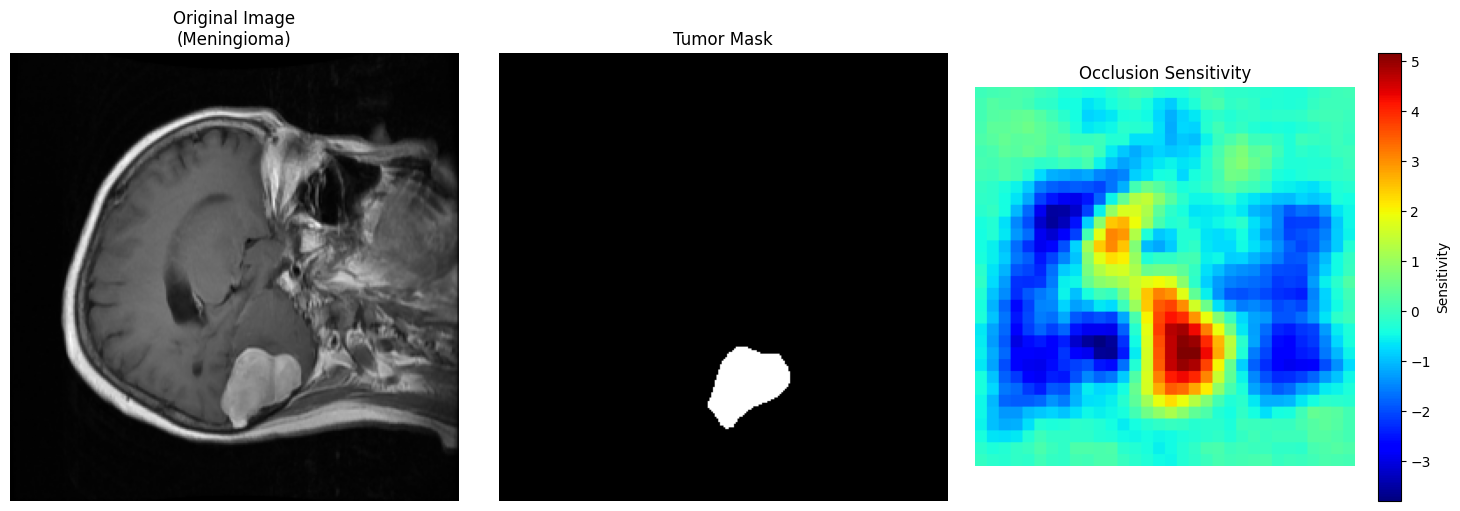

Processing Glioma sample 1/3


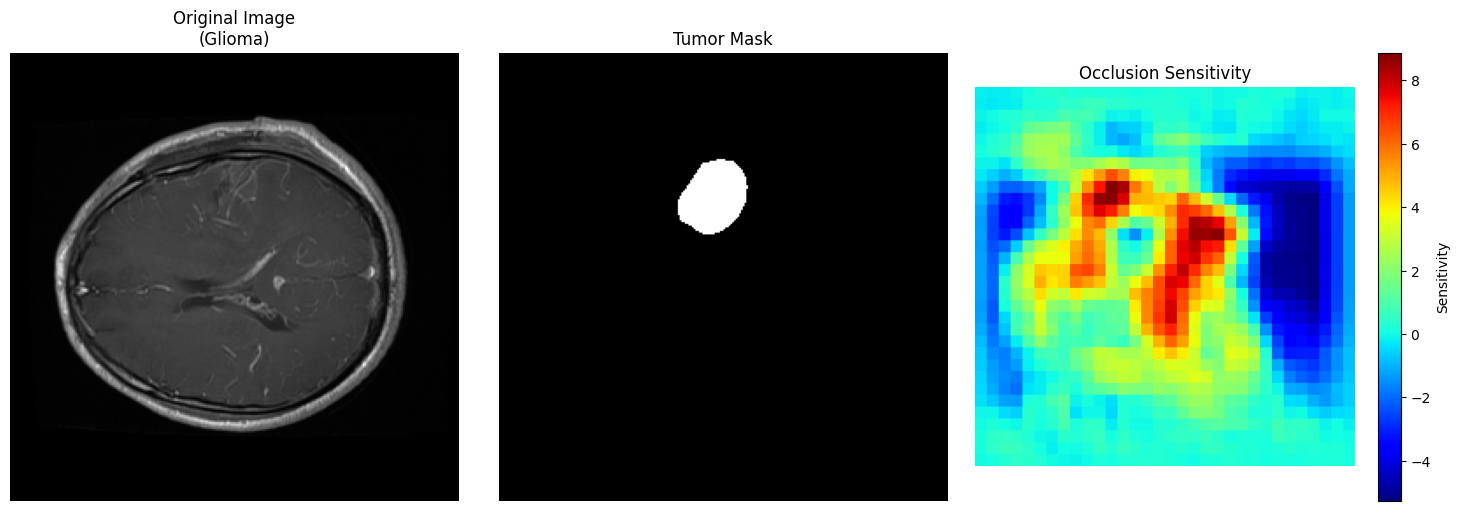

Processing Glioma sample 2/3


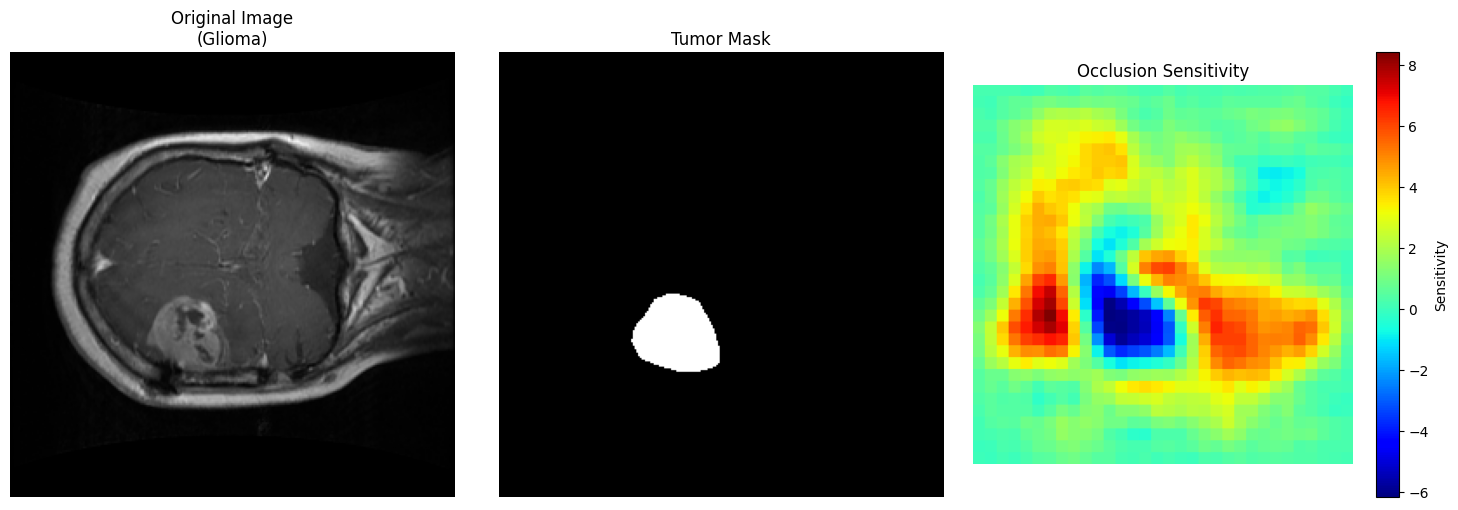

Processing Glioma sample 3/3


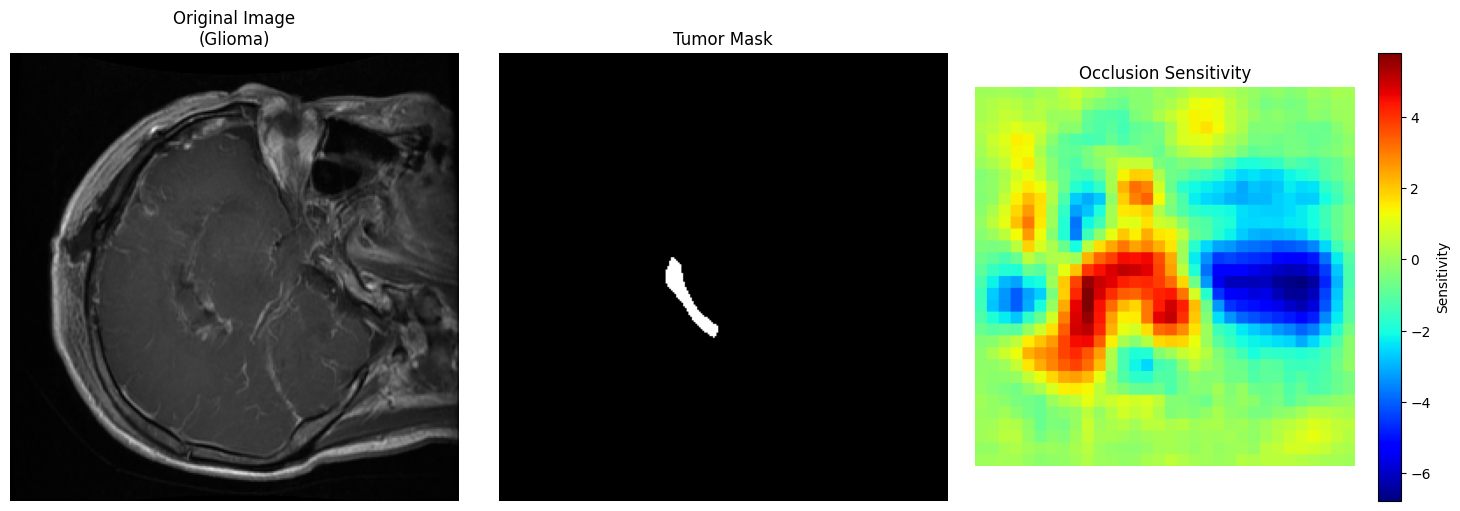

Processing Pituitary sample 1/3


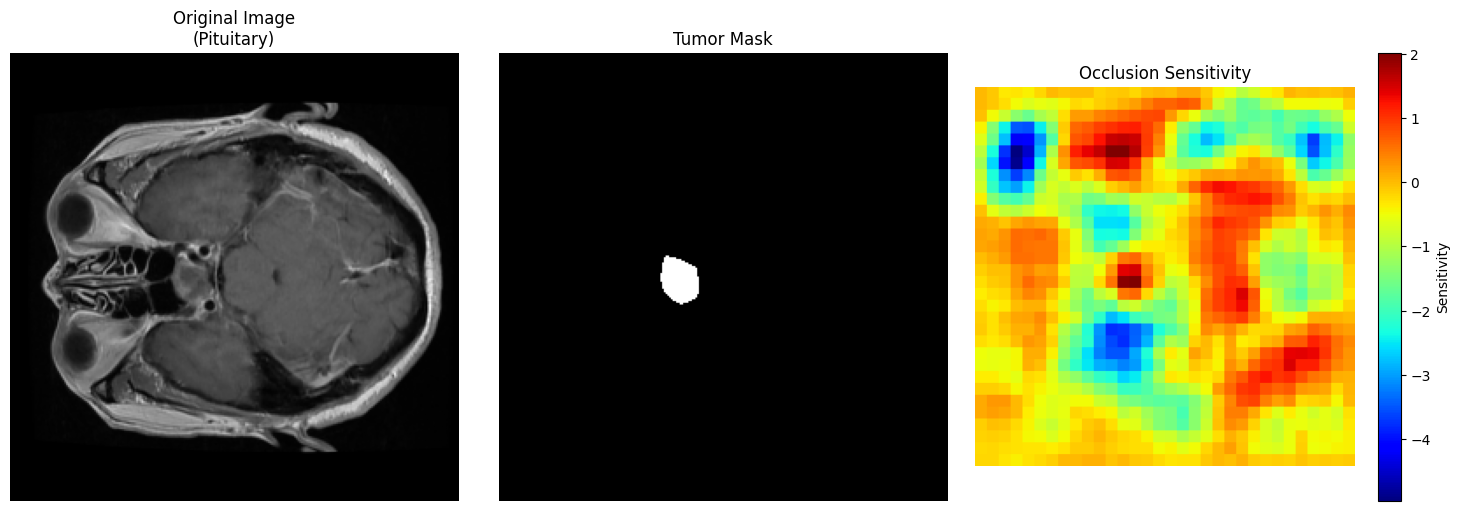

Processing Pituitary sample 2/3


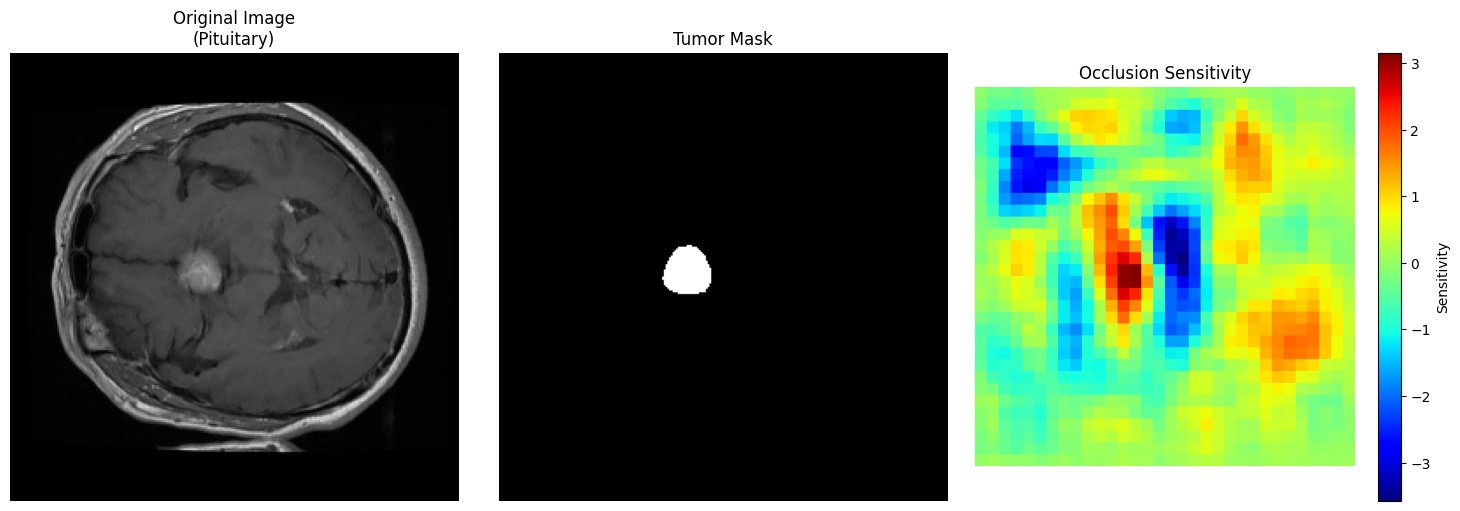

Processing Pituitary sample 3/3


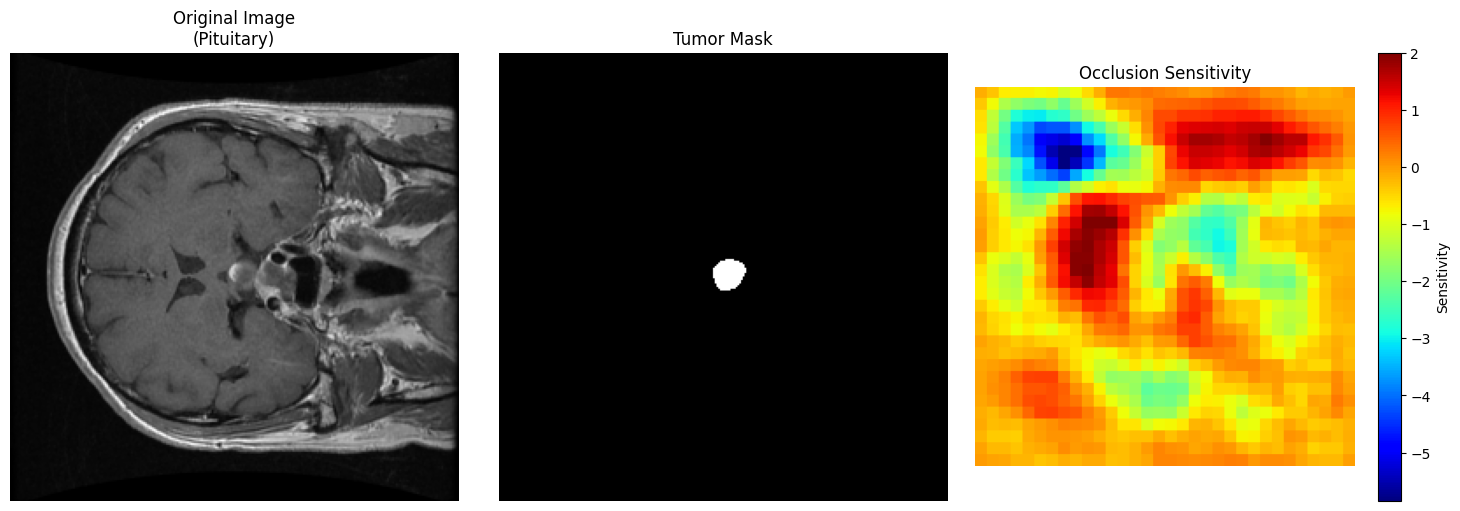


Model 2: Segmentation Embeddings into Classification
Processing Meningioma sample 1/3


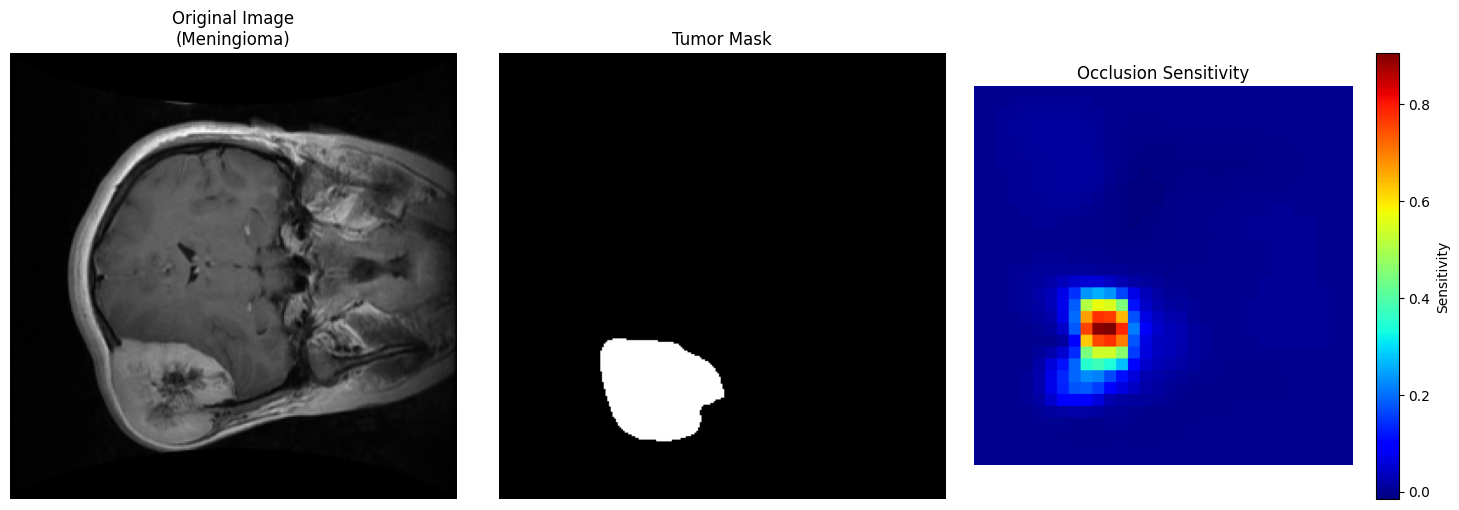

Processing Meningioma sample 2/3


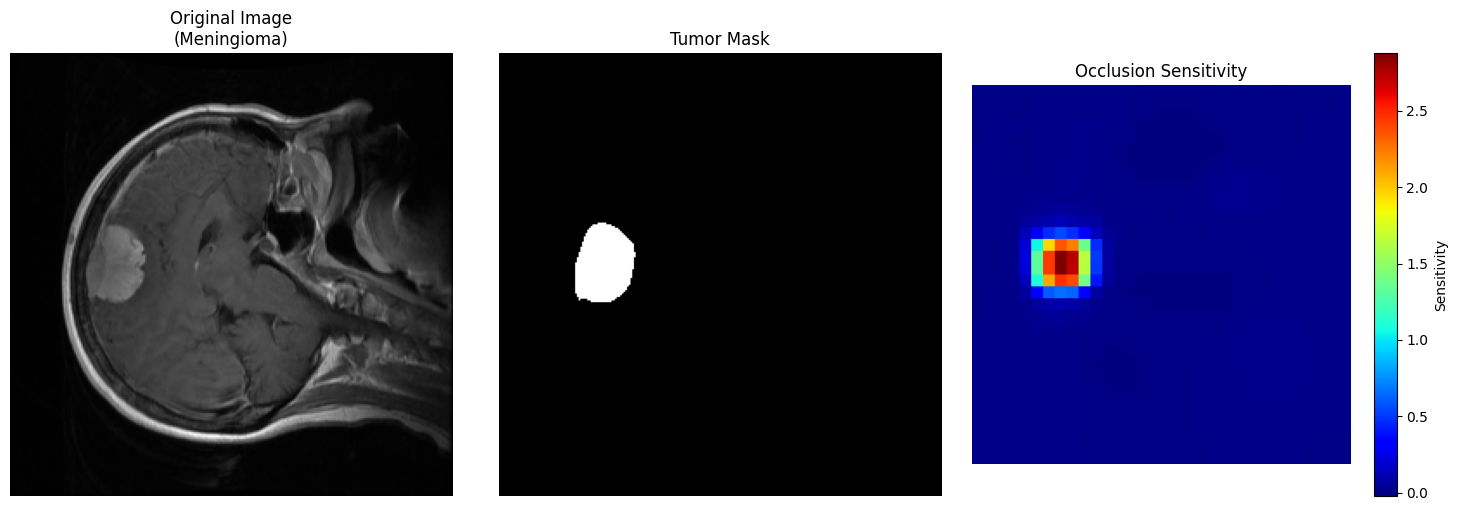

Processing Meningioma sample 3/3


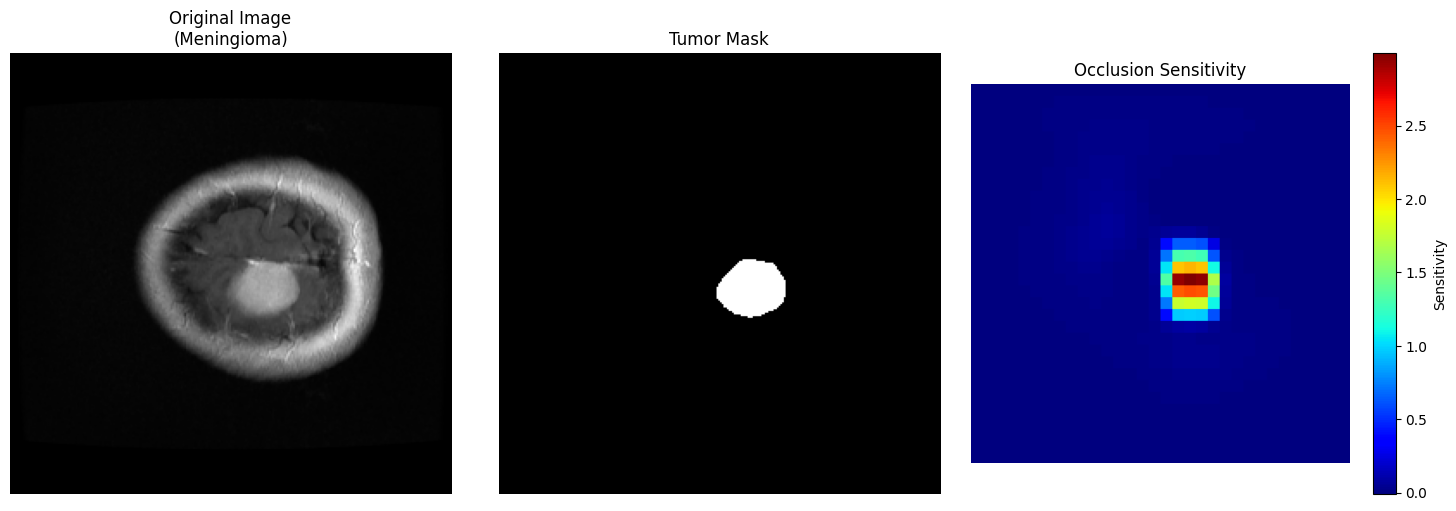

Processing Glioma sample 1/3


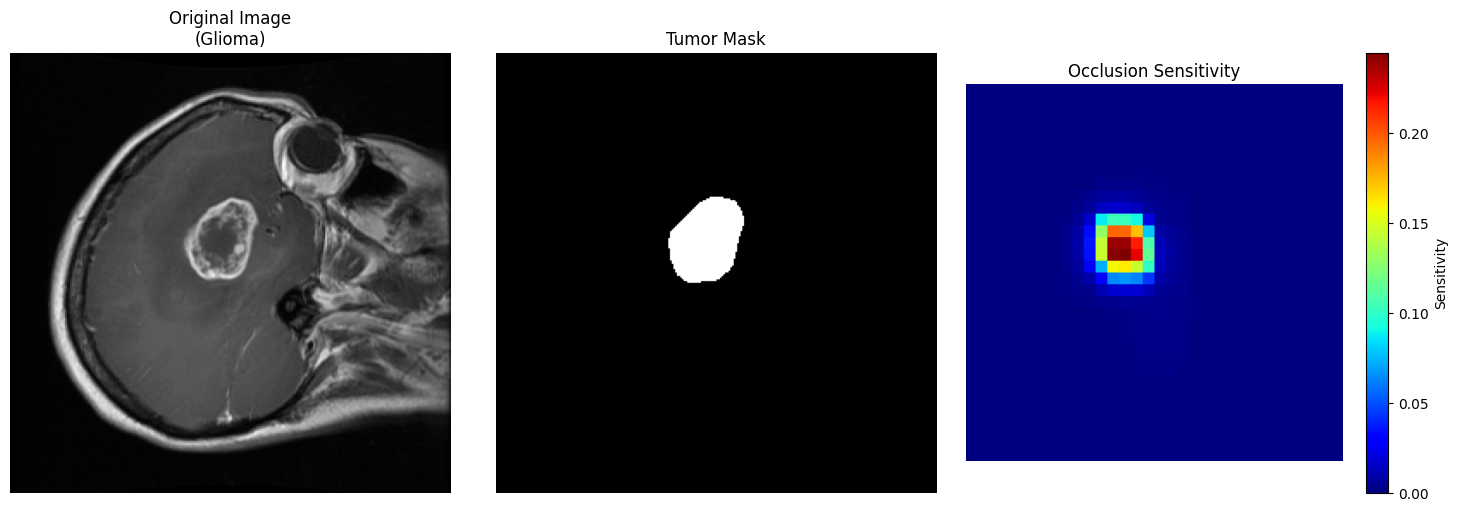

Processing Glioma sample 2/3


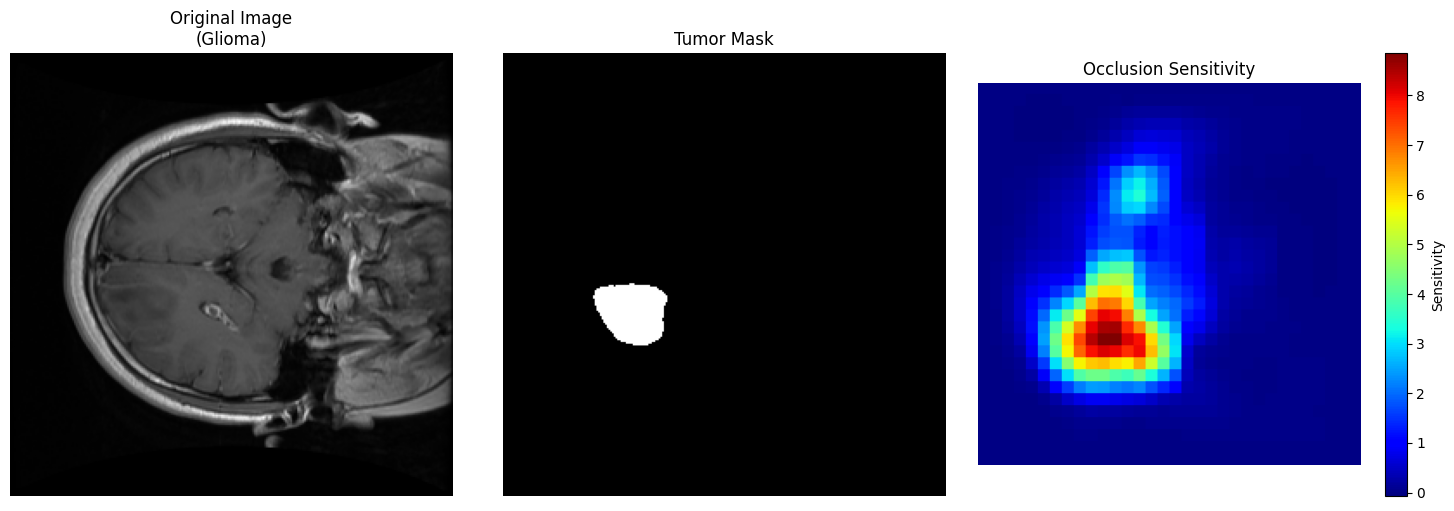

Processing Glioma sample 3/3


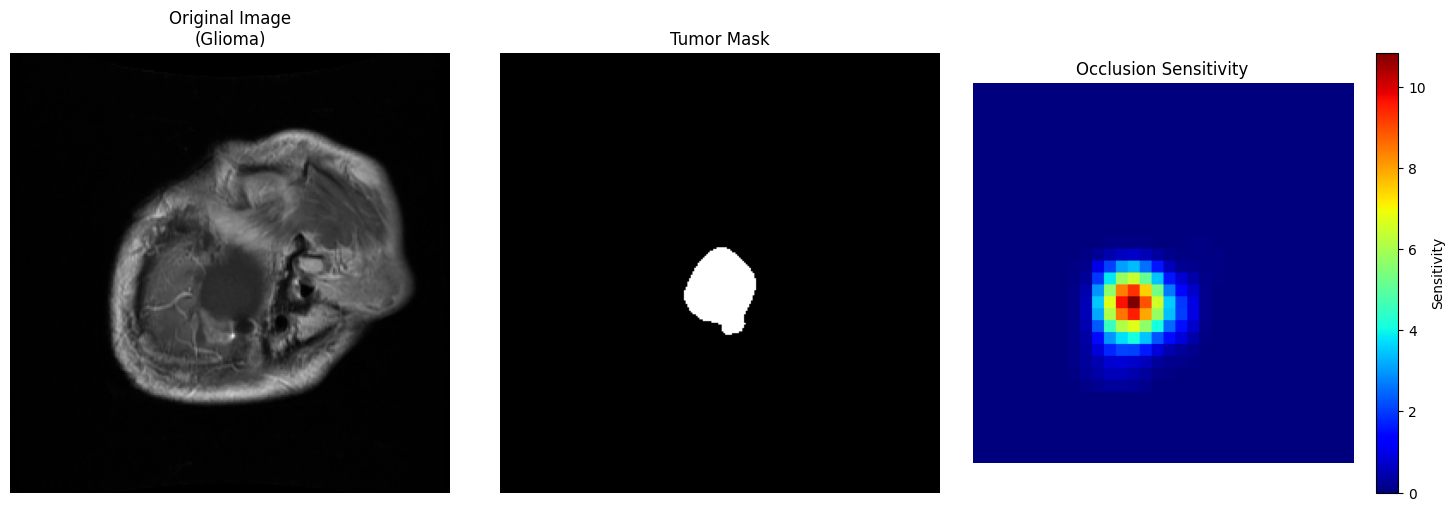

Processing Pituitary sample 1/3


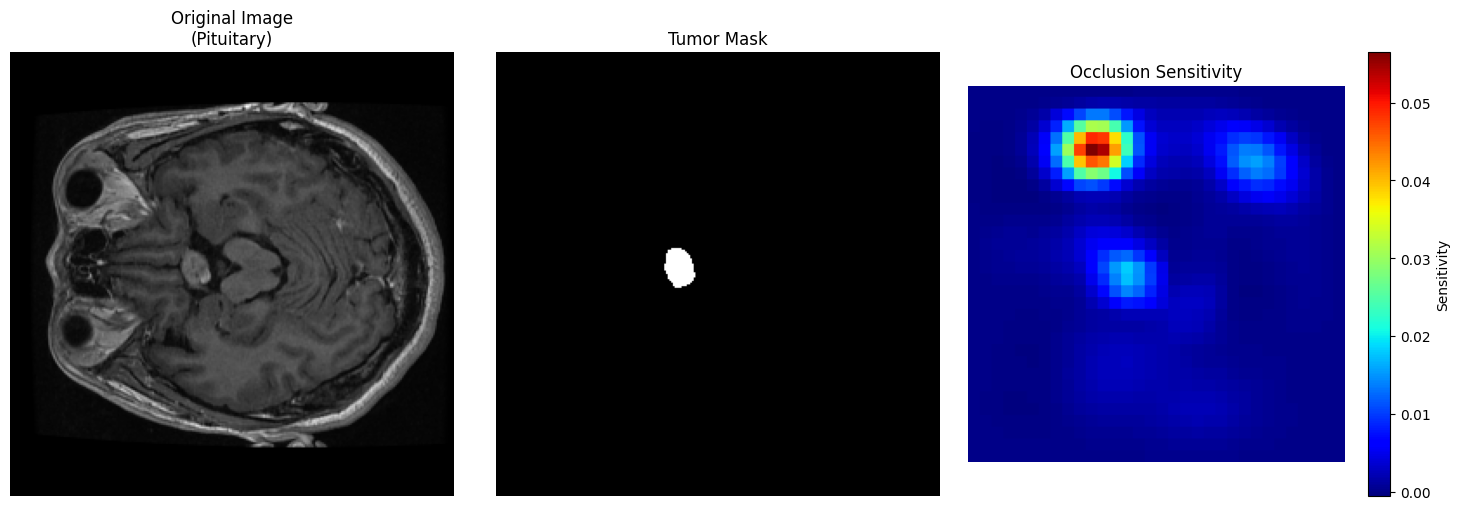

Processing Pituitary sample 2/3


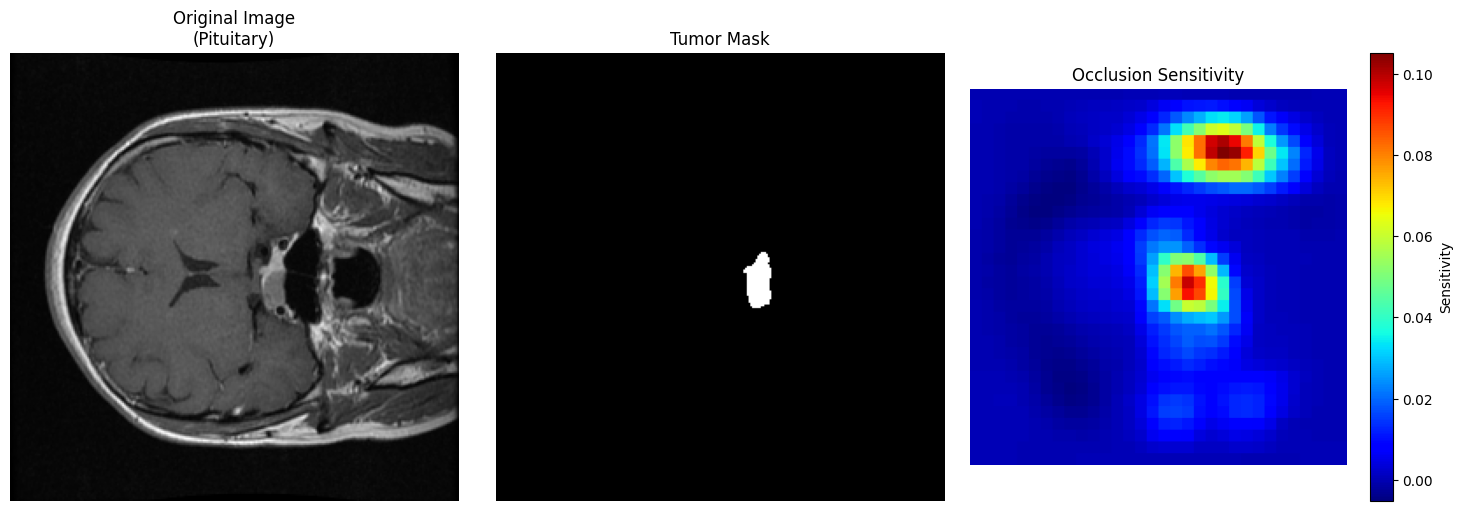

Processing Pituitary sample 3/3


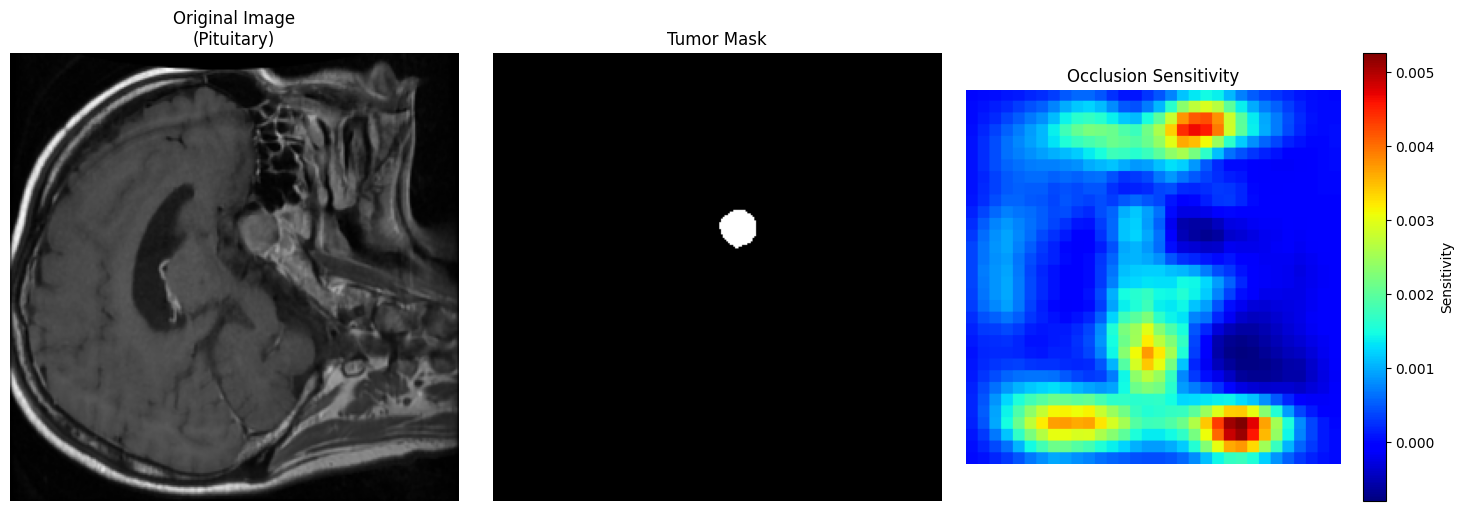

In [9]:
import matplotlib.pyplot as plt

def occlusion_sensitivity(model, image, label, mask_size=32, stride=8, batch_size=32):
    # Ensure image has batch dimension and is on the same device as model
    device = next(model.parameters()).device

    if len(image.shape) == 3:
        image = image.unsqueeze(0)

    image = image.to(device)
    width, height = image.shape[2], image.shape[3]

    # Get the original prediction and probability
    with torch.no_grad():
        _, class_logits = model(image)
        original_prob = F.softmax(class_logits, dim=1)[0, label].item()

    # Create occlusion patches
    occlusion_map = np.zeros((height, width))

    # Generate all possible occlusion positions
    coords = []
    for h in range(0, height - mask_size + 1, stride):
        for w in range(0, width - mask_size + 1, stride):
            coords.append((h, w))

    # Process in batches
    for i in range(0, len(coords), batch_size):
        batch_coords = coords[i:i + batch_size]
        batch_images = []

        # Create occluded images
        for h, w in batch_coords:
            occluded = image.clone()
            occluded[..., h:h + mask_size, w:w + mask_size] = 0  # Zero occlusion
            batch_images.append(occluded)

        # Stack into batch
        batch_tensor = torch.cat(batch_images)

        # Get predictions
        with torch.no_grad():
            _, batch_logits = model(batch_tensor)
            batch_probs = F.softmax(batch_logits, dim=1)

        # Record probability differences
        for idx, (h, w) in enumerate(batch_coords):
            prob = batch_probs[idx, label].item()
            diff = original_prob - prob
            # For each occluded pixel, accumulate the effect
            occlusion_map[h:h + mask_size, w:w + mask_size] += diff

    return occlusion_map


def run_occlusion_analysis(model, dataset, class_names, num_samples=3):
    # Create a test batch
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    samples_by_class = {i: [] for i in range(len(class_names))}

    # First collect samples for each class
    for images, masks, labels in data_loader:
        label = labels.item()
        if len(samples_by_class[label]) < num_samples:
            samples_by_class[label].append((images, masks, labels))

        # Check if we have enough samples for each class
        if all(len(samples) >= num_samples for samples in samples_by_class.values()):
            break

    # Now process each sample
    for class_idx, class_name in enumerate(class_names):
        for i, (images, masks, _) in enumerate(samples_by_class[class_idx]):
            print(f"Processing {class_name} sample {i + 1}/{num_samples}")

            # Run occlusion analysis
            occlusion_map = occlusion_sensitivity(model, images, class_idx)

            # Visualize results
            plt.figure(figsize=(15, 5))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(images[0, 0].cpu().numpy(), cmap='gray')
            plt.title(f"Original Image\n({class_name})")
            plt.axis('off')

            # Tumor mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[0, 0].cpu().numpy(), cmap='gray')
            plt.title("Tumor Mask")
            plt.axis('off')

            # Occlusion sensitivity map
            plt.subplot(1, 3, 3)
            plt.imshow(occlusion_map, cmap='jet')
            plt.colorbar(label='Sensitivity')
            plt.title("Occlusion Sensitivity")
            plt.axis('off')

            plt.tight_layout()
            plt.show()


# Define class names and test both models
class_names = ['Meningioma', 'Glioma', 'Pituitary']

print("Model 1: Classification Embeddings into Segmentation")
run_occlusion_analysis(model_cls_into_seg, data_module_multi.test_dataset, class_names)

print("\nModel 2: Segmentation Embeddings into Classification")
run_occlusion_analysis(model_seg_into_cls, data_module_multi.test_dataset, class_names)

# 7.2 LIME - Local Interpretable Model-agnostic Explanations